## Mounting Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## To visualise the input data

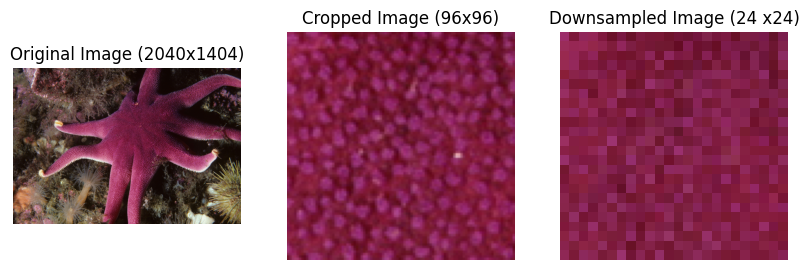

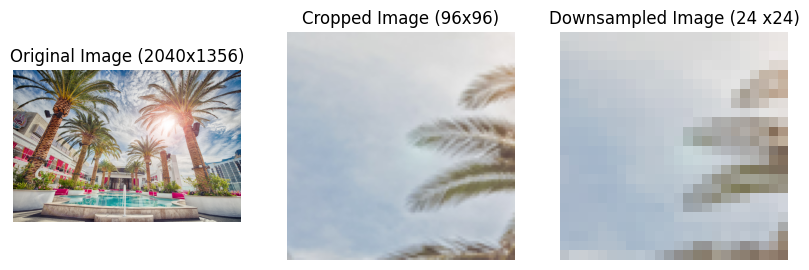

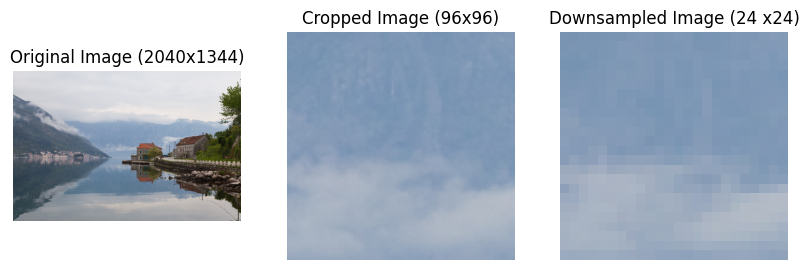

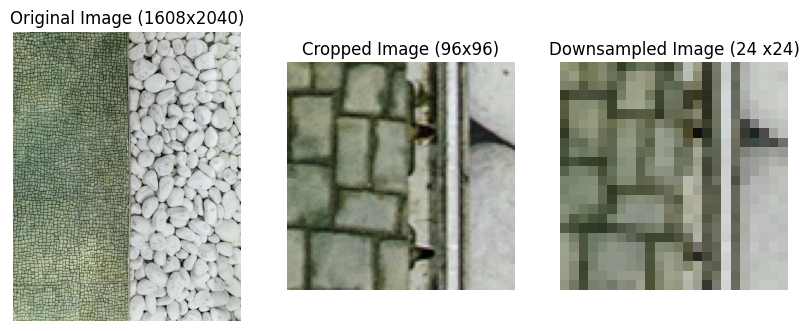

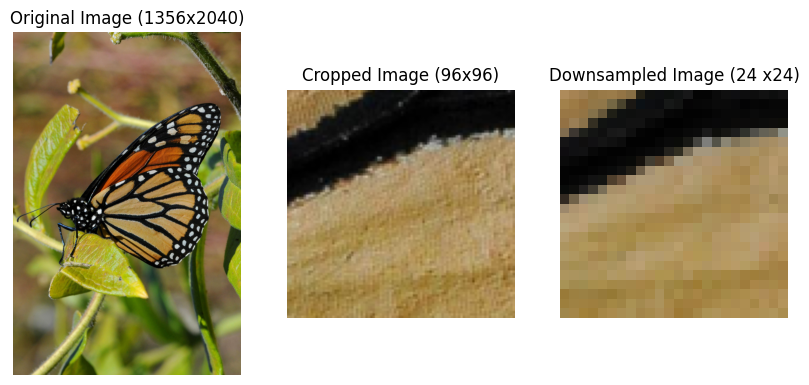

In [53]:
import matplotlib.pyplot as plt
from PIL import Image
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import albumentations as A
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import albumentations as A
from torchvision.utils import save_image
import os

# Load the PNG image
  # image_path = "/content/drive/MyDrive/City, University of London /BRP/GAN/hr_img/0400.png"  # Replace with the path to your PNG image
for im in os.listdir("/content/drive/MyDrive/City, University of London /BRP/GAN/hr_img/")[:5]:
  image = Image.open("/content/drive/MyDrive/City, University of London /BRP/GAN/hr_img/" + im)



  h =96
  w =96
  # Define the transformation to perform random center cropping
  transform_crop = A.CenterCrop(height=h, width=w)

  # Apply the transformation to the image
  transformed_crop = transform_crop(image=np.array(image))

  # Convert the cropped image back to PIL format
  cropped_image = Image.fromarray(transformed_crop["image"])

  downsample_transform = A.Resize(height=h // 4, width=w // 4, interpolation=Image.BICUBIC)

  # Apply the transformation to the cropped image
  downsampled_image = downsample_transform(image=np.array(cropped_image))

  # Convert the downsampled image back to PIL format
  downsampled_pil_image = Image.fromarray(downsampled_image["image"])


  fig, axes = plt.subplots(1, 3, figsize=(10, 5))

  # Display original image
  axes[0].imshow(image)
  axes[0].set_title(f"Original Image ({image.size[0]}x{image.size[1]})")
  axes[0].axis("off")

  # Display cropped image
  axes[1].imshow(cropped_image)
  axes[1].set_title(f"Cropped Image ({h}x{w})")
  axes[1].axis("off")

  # Display downsampled image
  axes[2].imshow(downsampled_pil_image)
  axes[2].set_title(f"Downsampled Image ({h//4} x{w//4})")
  axes[2].axis("off")

  plt.show()



  # save_image(downsampled_image*0.5 + 0.5, "abcd.png")
  # save_image(transformed_crop, "abcde.png")

## *SRGAN from scratch (paper)*

### Building Blocks

In [37]:
import torch
from torch import nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ConvBlock(nn.Module):
  def __init__(
      self,
      in_channels,
      out_channels,
      discriminator=False,
      # to specify if its in discriminator or not
      use_act = True, # will use an activation or not
      use_bn = True, # Use batchnorm or not
      **kwargs,
      ):

    super().__init__()
    self.use_act = use_act
    self.cnn = nn.Conv2d(in_channels, out_channels, **kwargs, bias = not use_bn )  # Bcoz Bias can be false when we are not using batchnorm
    self.bn = nn.BatchNorm2d(out_channels) if use_bn else nn.Identity()
    self.act = (     #activatiom
        nn.LeakyReLU(0.2, inplace=True)
        if discriminator
        else nn.PReLU(num_parameters=out_channels)  #We can train Prelu to spcify the slope (to read more) , that means each of the out_channels will have a seperate slope. Set as per paper
                    )

  def forward(self,x):
    return self.act(self.bn(self.cnn(x))) if self.use_act else self.bn(self.cnn(x))



class UpsampleBlock(nn.Module):
  def __init__(self, in_c, scale_factor):  # in_c --> in channels
    super().__init__()
    self.conv = nn.Conv2d(in_c, in_c * scale_factor **2, 3,1,1)  # The reason for increasing channels here (* scalefactor**2) instead fo bilinear upsample (i.e increase height and width), because we are using pixelshuffle
    self.ps = nn.PixelShuffle(scale_factor)  # in_c * 4, H, W --> in_c, H*2, W*2
    self.act = nn.PReLU(num_parameters = in_c)  # in_c because after the pixel shifter it will still be in c number of channels


  def forward(self,x):
    return self.act(self.ps(self.conv(x))) #activation of pixel shuffle of conv

class ResidualBlock(nn.Module):
  def __init__(self, in_channels):
    super().__init__()
    self.block1 = ConvBlock(
        in_channels,
        in_channels, #We won't modify number of channels as per architecture in paper
        kernel_size = 3,
        stride = 1,
        padding = 1
        )

    self.block2 = ConvBlock(
        in_channels,
        in_channels, #We won't modify number of channels as per architecture in paper
        kernel_size = 3,
        stride = 1,
        padding = 1,
        use_act=False,
        )

  def forward (self,x):
    out = self.block1(x)
    out = self.block2(out)

    return out + x # "+ x" because we need skip connection that was inputted to the block


class Generator(nn.Module):
  def __init__(self, in_channels=3, num_channels=64, num_blocks=16): # Values as per architecture in paper
     super().__init__()
     self.initial = ConvBlock(in_channels, num_channels, kernel_size =9, stride = 1, padding =4, use_bn = False) # False, since no batch norm in the beginning in paper)
     self.residuals = nn.Sequential(*[ResidualBlock(num_channels) for _ in range(num_blocks)]) #List comprehension to create all of 16 block, and asterisk to unwrap that list of residual block and turning it into Sequential
     self.convblock = ConvBlock(num_channels, num_channels, kernel_size = 3, stride =1 , padding =1, use_act=False)
     self.upsamples = nn.Sequential(UpsampleBlock(num_channels, scale_factor =2),UpsampleBlock(num_channels, scale_factor =2))
     self.final = ConvBlock(num_channels,in_channels, kernel_size = 9 , stride=1, padding=4 )

  def forward(self,x):
    initial = self.initial(x)
    x = self.residuals(initial) #initial specidied, bcoz we want skip conncetion after the first conv layer
    x = self.convblock(x) + initial # elementwise sum from paper archi
    x = self.upsamples(x)
    return torch.tanh(self.final(x)) #not clear they used tanh, (but they normalised between 1 & -1, so it make sense to use tanh)

class Discriminator(nn.Module):
  def __init__(self, in_channels = 3, features = [64,64,128,128,256,256,512,512] ):
     #mentioned in architecture
      super().__init__()

      blocks = []

      for idx, feature in enumerate(features):
        blocks.append(
            ConvBlock(
                in_channels,
                feature,
                kernel_size=3,
                stride=1 + idx % 2, # stride is 1 in the beginning or architecture then 2 then 1 then 2 and so on
                # when index is 0 its 1 + 1 % 2 = 1+0 =0, similarly when idx is 1, 1+1%2 =2 , since anything modulus(remainder) by 2 is either 0 or 1
                padding=1,
                discriminator=True, # since we have set it to false in ConV block
                use_act=True,
                use_bn = False if idx==0 else True # Since batch norm is for all blocks except the first one in paper
                )
                )
        in_channels = feature

        self.blocks = nn.Sequential(*blocks) #unwrapping the blocks list

        # classifier turn now , flow from paper = Dense (1024) --> LeakyReLU-->Dense-->Sigmoid

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((6,6)), # its 6x6 when its outputted, for instance, if we keep on dividing by stride of 2
            # AdaptiveAvgPool2d won't do anythong if ots 96x96, but will make sure it runs when its bigger value like 128,192
            nn.Flatten(),
            nn.Linear(512*6*6, 1024), # 512 is the number of channels in output
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024,1)
            )


  def forward(self,x):
      x = self.blocks(x)
      return self.classifier(x)

      #They used sigmoid inpaper, we will specify BC with logits which includes sigmoid anyways




def test():

  low_resolution =100 # High resolution is 96x96 when we divide by 4 lower resolution is 24x24. Thats what we are going to run this with
  # so when we upsample 24x24 --> we get 96x96 from the generator, then we run throgh discriminator where we get only one single output, where batch size is 5

  with torch.autocast(device_type="cuda"):
    x = torch.randn((5, 3, low_resolution, low_resolution))  #batch size, number of channels, Image height, Image width
    gen = Generator()
    gen_out=gen(x)
    disc = Discriminator()
    disc_out = disc(gen_out)

    print(gen_out.shape)
    print(disc_out.shape)

if __name__ == "__main__":
  test()



/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


torch.Size([5, 3, 400, 400])
torch.Size([5, 1])


### LOSS
Here they used GAN loss and Perceptual loss (using VGG).

Basically they run the image from VGG, we get some feature representation and we want to minimise the difference between Upscaled image and Original high quality image, when they have run through VGG and we obtained the feature

In [38]:
import torch.nn as nn
from torchvision.models import vgg19 # They used vgg19 specifically
# import config

# The layer that they used the output from VGG is a specific one,
# in paper its --> phi_5,4, which is I think 5th conv layer before maxpooling but after activation, something like that


class VGGLoss(nn.Module):
  def __init__(self):
    super().__init__()
    self.vgg = vgg19(pretrained=True).features[:36].eval().to(DEVICE) #we get 36 list of features, which is calculated from above phi_5,4
    #.eval() so we won't update the weights, also may be they used dropout so its called here
    self.loss = nn.MSELoss()


    for param in self.vgg.parameters():
      param.required_grad = False # Not to update it


  def forward(self,input,target): #input -->Upscaled low res image , target --> original high quality image
     vgg_input_features = self.vgg(input)
     vgg_target_features = self.vgg(target)

     return self.loss(vgg_input_features, vgg_target_features)



### Configurations

In [44]:
import torch
from PIL import Image
import albumentations as A #for data augmentation
from albumentations.pytorch import ToTensorV2

LOAD_MODEL = False
SAVE_MODEL = True
# CHECKPOINT_GEN = "gen.pth.tar" # CHECKPOINT FILES
# CHECKPOINT_DISC = "disc.pth.tar"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-4
NUM_EPOCHS = 200
BATCH_SIZE = 16
NUM_WORKERS = 0
HIGH_RES = 96
LOW_RES = HIGH_RES // 4
IMG_CHANNELS = 3


#After both_transform, for High res image will normalize it between -1 and 1, then convert it into tensor
highres_transform = A.Compose(
    [
        A.Normalize(mean=[-1, -1, -1], std=[1, 1, 1]), # as per paper
        ToTensorV2(),
    ]
)

# After both_transform, for low resol, take that high quality which is outputted from both_transforms
# make it to 24x24 low resolution, then normalize it b/w 0 and 1 as per paper
lowres_transform = A.Compose(
    [
        A.Resize(width=LOW_RES, height=LOW_RES, interpolation=Image.BICUBIC),
        A.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
        ToTensorV2(), #converts to pytorch format (C,H,W)
    ]
)

# Get the image, random crop (eg :-96,96)
both_transforms = A.Compose(
    [
        A.RandomCrop(width=HIGH_RES, height=HIGH_RES),
        A.HorizontalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
    ]
)

test_transform = A.Compose(
    [
        A.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
        ToTensorV2(), #converts to pytorch format (C,H,W)
    ]
)

In [45]:
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
from PIL import Image

import os
import torch
from torch.utils import data
from PIL import Image as PILImage
import numpy as np
from torchvision import transforms

root_dir = "/content/drive/MyDrive/City, University of London /BRP/GAN/" #/ZIP.data.visi.ee.ethz.ch_cvl_DIV2_DIV2_trai_HRnQucRj9uNbbGLMapMO4iJPZws0wd-EGldnD5rPD2wzU.zip/DIV2K_train_HR/"
class SuperResolutionDataset(Dataset):
    def __init__(self, root_dir):
        super(SuperResolutionDataset, self).__init__()
        self.data = []
        self.root_dir = root_dir  #os.path.join(root_dir, 'image_pairs')  # Assuming image_pairs subfolder

        hr_img_dir = os.path.join(self.root_dir,"hr_img/")

        for hr_img in sorted(os.listdir(hr_img_dir)):
          hr_img_path = os.path.join(hr_img_dir,hr_img)
          self.data.append(hr_img_path)



    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):

        img_path = self.data[index]

        img = np.array(Image.open(img_path))

        transformed_img = both_transforms(image=img)['image']
        lowres_image = lowres_transform(image=transformed_img)['image']
        highres_image = highres_transform(image=transformed_img)['image']

        return lowres_image, highres_image


### Test the Dataloader

In [46]:
dataset = SuperResolutionDataset(root_dir=root_dir)
loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    pin_memory=True,
    num_workers=NUM_WORKERS,
)

In [55]:
from torchvision.utils import save_image

# loader.dataset.__getitem__(0)[0]
loader.dataset.data[0]

# save_image(loader.dataset.__getitem__(0)[0],"13.png")

'/content/drive/MyDrive/City, University of London /BRP/GAN/hr_img/0001.png'

### Utils


In [42]:
import torch
import os
# import config
import numpy as np
from PIL import Image
from torchvision.utils import save_image


def gradient_penalty(critic, real, fake, device): #actually not needed
    BATCH_SIZE, C, H, W = real.shape
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake.detach() * (1 - alpha)
    interpolated_images.requires_grad_(True)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty


def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr


# Here, will send a folder of low res images, and run this plot_examples,it will upscale the image with current generator to get high upscaled images
def plot_examples(low_res_folder, gen):
    files = os.listdir(low_res_folder)

    gen.eval()
    for file in files:

        image = "/root/tensorflow_datasets/downloads/extracted/ZIP.data.visi.ee.ethz.ch_cvl_DIV2_DIV2_vali_LRpQpdHEuI3k6NMA2PsrkExS_pOyspikiZaXdg18u21VM.zip/DIV2K_valid_LR_bicubic/X4/0801x4.png"
        image = Image.open(image)
        with torch.no_grad():
            upscaled_img = gen(
                test_transform(image=np.asarray(image))["image"]
                .unsqueeze(0)
                .to(DEVICE)
            )
        save_image(upscaled_img * 0.5 + 0.5, file)
    gen.train()

### Training

In [47]:
import torch
# import config
from torch import nn
from torch import optim
# from utils import load_checkpoint, save_checkpoint, plot_examples
# from loss import VGGLoss
from torch.utils.data import DataLoader
# from model import Generator, Discriminator
from tqdm import tqdm
# from dataset import MyImageFolder
from google.colab import files


torch.backends.cudnn.benchmark = True


def train_fn(loader, disc, gen, opt_gen, opt_disc, mse, bce, vgg_loss):
    loop = tqdm(loader, leave=True)

    for idx, (low_res, high_res) in enumerate(loop):
        high_res = high_res.to(DEVICE)
        low_res = low_res.to(DEVICE)

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        fake = gen(low_res)
        disc_real = disc(high_res)
        disc_fake = disc(fake.detach())
        disc_loss_real = bce(
            disc_real, torch.ones_like(disc_real) - 0.1 * torch.rand_like(disc_real)
        ) #one sided label smoothing (extra), rest is as per paper

        disc_loss_fake = bce(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = disc_loss_fake + disc_loss_real

        opt_disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        # Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        disc_fake = disc(fake)
        l2_loss = mse(fake, high_res)
        adversarial_loss = 1e-3 * bce(disc_fake, torch.ones_like(disc_fake)) #to play around with loss terms
        loss_for_vgg = 0.006 * vgg_loss(fake, high_res)
        gen_loss =  loss_for_vgg + adversarial_loss
        # gen_loss =  l2_loss
        print(gen_loss)
        opt_gen.zero_grad()
        gen_loss.backward()
        opt_gen.step()

        # if idx % 200 == 0:

        #     low_res_valid_folder = "/root/tensorflow_datasets/downloads/extracted/ZIP.data.visi.ee.ethz.ch_cvl_DIV2_DIV2_vali_LRpQpdHEuI3k6NMA2PsrkExS_pOyspikiZaXdg18u21VM.zip/DIV2K_valid_LR_bicubic/X4"
        #     plot_examples(low_res_valid_folder, gen)


def main():
    # dataset = MyImageFolder(root_dir="new_data/")



    dataset = SuperResolutionDataset(root_dir=root_dir)
    loader = DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        pin_memory=True,
        num_workers=NUM_WORKERS,
    )


    # loader = DataLoader(dataset, batch_size=128) #, num_workers=8)


    gen = Generator(in_channels=3).to(DEVICE)
    disc = Discriminator(in_channels=3).to(DEVICE)
    opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999))
    opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999))
    mse = nn.MSELoss()
    bce = nn.BCEWithLogitsLoss()
    vgg_loss = VGGLoss()

    if LOAD_MODEL:

        # load_checkpoint(
        #     CHECKPOINT_GEN,
        #     gen,
        #     opt_gen,
        #     LEARNING_RATE,
        # )
        # load_checkpoint(
        #    CHECKPOINT_DISC, disc, opt_disc, LEARNING_RATE,
        # )


# def load_checkpoint(checkpoint_file, model, optimizer, lr):
        print("=> Loading checkpoint")
        checkpoint = torch.load("/content/gen_100_epochs.tar")
        gen.load_state_dict(checkpoint["state_dict"])
        opt_gen.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in opt_gen.param_groups:
        param_group["lr"] = LEARNING_RATE

    for epoch in range(NUM_EPOCHS):
        train_fn(loader, disc, gen, opt_gen, opt_disc, mse, bce, vgg_loss)
        print(epoch)
        if epoch%100 == 0:
          if SAVE_MODEL:
              # save_checkpoint(gen, opt_gen, filename=CHECKPOINT_GEN)
              # save_checkpoint(disc, opt_disc, filename=CHECKPOINT_DISC)

              # def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
              print("=> Saving checkpoint Generator")
              checkpoint = {
                  "state_dict": gen.state_dict(),
                  "optimizer": opt_gen.state_dict(),
              }

              torch.save(checkpoint, '/content/gen_1000_epochs.tar')
              # files.download('/content/gen_1000_epochs.tar')
              # print("Downloading checkpoint Generator")


              print("=> Saving checkpoint Discriminator")

              checkpoints = {
                  "state_dict": disc.state_dict(),
                  "optimizer": opt_disc.state_dict(),
              }
              torch.save(checkpoints, '/content/disc_1000_epochs.tar')
              # print("Downloading checkpoint Discriminator")
              # files.download('/content/disc_1000_epochs.tar')


              break



        print(epoch, "Completed")



if __name__ == "__main__":
    main()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/50 [00:00<?, ?it/s]

tensor(0.0055, grad_fn=<AddBackward0>)


  2%|▏         | 1/50 [00:39<31:54, 39.07s/it]


KeyboardInterrupt: 

In [ ]:
from google.colab import files

# Save your checkpoint
# torch.save(your_checkpoint_data, 'checkpoint.pth')

# Flush the output buffers
import sys
sys.stdout.flush()

# Download the checkpoint file
files.download('checkpoint.pth')


### To load model and test on images

In [ ]:
def plot_examples(low_res_folder, gen):
    files = os.listdir(low_res_folder)

    gen.eval()
    for file in files:

        image = "/root/tensorflow_datasets/downloads/extracted/ZIP.data.visi.ee.ethz.ch_cvl_DIV2_DIV2_vali_LRpQpdHEuI3k6NMA2PsrkExS_pOyspikiZaXdg18u21VM.zip/DIV2K_valid_LR_bicubic/X4/0801x4.png"
        image = Image.open(image)
        with torch.no_grad():
            upscaled_img = gen(
                test_transform(image=np.asarray(image))["image"]
                .unsqueeze(0)
                .to(DEVICE)
            )
        save_image(upscaled_img * 0.5 + 0.5, file)
    gen.train()


----------------------------------------------------------------------------------------------
## Rough work below


### Dataset

In [ ]:
# import os
# import numpy as np
# from torch.utils.data import Dataset, DataLoader
# from PIL import Image

# import os
# import torch
# from torch.utils import data
# from PIL import Image as PILImage
# import numpy as np
# from torchvision import transforms


# class SuperResolutionDataset(Dataset):
#     def __init__(self, root_dir,**kwargs):
#         super(SuperResolutionDataset, self).__init__()
#         self.data = []
#         self.root_dir = root_dir  #os.path.join(root_dir, 'image_pairs')  # Assuming image_pairs subfolder
#         self.img_size = kwargs['image_size']

#         low_res_path = "ZIP.data.visi.ee.ethz.ch_cvl_DIV2_DIV2_trai_LR8Aa4N_TrUrgpCaoBR45tbRme786TIXlJHQydu3Bt3jo.zip/DIV2K_train_LR_bicubic/X4/"
#         high_res_path = "ZIP.data.visi.ee.ethz.ch_cvl_DIV2_DIV2_trai_HRnQucRj9uNbbGLMapMO4iJPZws0wd-EGldnD5rPD2wzU.zip/DIV2K_train_HR/"
#         low_res_dir = os.path.join(self.root_dir, low_res_path)
#         high_res_dir = os.path.join(self.root_dir, high_res_path)

#         low_res_files = os.listdir(low_res_dir)


#         for low_res_img, high_res_img in zip(sorted(os.listdir(low_res_dir)),sorted(os.listdir(high_res_dir))):
#            low_res_path = os.path.join(low_res_dir, low_res_img)
#            high_res_path = os.path.join(high_res_dir, high_res_img)
#            self.data.append((low_res_path, high_res_path))



#         # for filename in low_res_files:
#         #     low_res_path = os.path.join(low_res_dir, filename)
#         #     # Assuming high-res filename matches low-res filename (e.g., replace "_low" with "")
#         #     high_res_path = os.path.join(high_res_dir, filename.replace("_low", ""))  # Adjust for naming convention
#         #     self.data.append((low_res_path, high_res_path))

#     def transform_img(self, img,size):
#         h_, w_ = size, size
#         im_size = tuple([h_, w_])
#         transform_image = transforms.Compose([
#                                transforms.Resize(size),
#                                transforms.CenterCrop(size),
#                                transforms.ToTensor(),
#                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#                            ])

#         img = transform_image(img)
#         return img

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, index):
#         low_res_path, high_res_path = self.data[index]
#         low_res_image = Image.open(low_res_path)
#         high_res_image = Image.open(high_res_path)
#         hr = 96
#         low_res = self.transform_img(low_res_image,hr//4)
#         high_res = self.transform_img(high_res_image, hr)

#         # low_res = config.lowres_transform(image=low_res_image)["image"]
#         # high_res = config.highres_transform(image=high_res_image)["image"]
#         return low_res, high_res

### *To download images from colab to drive*

In [ ]:
# from google.colab import files
# import shutil
# import os
# from PIL import Image




# # Zip the folder containing your data
# # shutil.make_archive("/content/data", "zip", "/root/tensorflow_datasets/downloads/extracted/ZIP.data.visi.ee.ethz.ch_cvl_DIV2_DIV2_trai_HRnQucRj9uNbbGLMapMO4iJPZws0wd-EGldnD5rPD2wzU.zip/DIV2K_train_HR")
# path = "/root/tensorflow_datasets/downloads/extracted/ZIP.data.visi.ee.ethz.ch_cvl_DIV2_DIV2_trai_LR8Aa4N_TrUrgpCaoBR45tbRme786TIXlJHQydu3Bt3jo.zip/DIV2K_train_LR_bicubic/X4/"
# for i in sorted(os.listdir(path)):
# # Download the zip file to your local PC
#   # print(path+ i)
#   print(i)
#   img = Image.open(path + i)
#   directory = "/content/drive/MyDrive/GAN/lr_img/"
#   img.save(f'{directory}/{i}')

### To download and use DIV2k from tensorflow if required

In [ ]:
import tensorflow_datasets as tfds

div2k_data = tfds.image.Div2k(config="bicubic_x4")
div2k_data.download_and_prepare()



EXTRACTING {'train_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X4.zip', 'valid_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X4.zip', 'train_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip', 'valid_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip'}


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/800 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/div2k/bicubic_x4/2.0.0.incompleteWZEK8O/div2k-train.tfrecord*...:   0%|   …

Generating validation examples...:   0%|          | 0/100 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/div2k/bicubic_x4/2.0.0.incompleteWZEK8O/div2k-validation.tfrecord*...:   0…

Dataset div2k downloaded and prepared to /root/tensorflow_datasets/div2k/bicubic_x4/2.0.0. Subsequent calls will reuse this data.


In [ ]:
import os
root_dir = "/root/tensorflow_datasets/downloads/extracted/" #/ZIP.data.visi.ee.ethz.ch_cvl_DIV2_DIV2_trai_HRnQucRj9uNbbGLMapMO4iJPZws0wd-EGldnD5rPD2wzU.zip/DIV2K_train_HR/"
low_res_dir = "ZIP.data.visi.ee.ethz.ch_cvl_DIV2_DIV2_trai_LR8Aa4N_TrUrgpCaoBR45tbRme786TIXlJHQydu3Bt3jo.zip/DIV2K_train_LR_bicubic/X4/"

os.path.join(root_dir + low_res_dir)

low_res_path = "ZIP.data.visi.ee.ethz.ch_cvl_DIV2_DIV2_trai_LR8Aa4N_TrUrgpCaoBR45tbRme786TIXlJHQydu3Bt3jo.zip/DIV2K_train_LR_bicubic/X4/"
high_res_path = "ZIP.data.visi.ee.ethz.ch_cvl_DIV2_DIV2_trai_HRnQucRj9uNbbGLMapMO4iJPZws0wd-EGldnD5rPD2wzU.zip/DIV2K_train_HR/"
low_res_dir = os.path.join(root_dir, low_res_path)
high_res_dir = os.path.join(root_dir, high_res_path)

# for a,b in zip(sorted(os.listdir(low_res_dir)),sorted(os.listdir(high_res_dir))):

#   print(a,b)



## **Generator and Discriminator from Scratch (DCGAN)**

In [ ]:
import torch
import torch.nn as nn

class Discriminator(nn.Module):  # in paper they said they didnt use batch norm in first layer of discriminator and last layer of generator
  def __init__(self,channels_img, features_d):
    super(Discriminator,self).__init__()
    self.disc = nn.Sequential(
        #Input = N x channels_img x 64 x 64
        nn.Conv2d(
            channels_img, features_d, kernel_size=4, stride = 2, padding=1
        ), #32 x 32
        nn.LeakyReLU(0.2),    #skipping batch norm here as per paper DCGAN
        self._block(features_d, features_d *2, 4,2,1),  #16x16
        self._block(features_d*2, features_d *4, 4,2,1), #8x8
        self._block(features_d*4, features_d *8, 4,2,1), #4x4
        nn.Conv2d(features_d*8,1,kernel_size=4, stride =2, padding = 0), #1x1 (single value if its a fake img or real img (i.e 0 or 1))
        nn.Sigmoid(),
        )

  def _block(self,in_channels, out_channels, kernel_size,stride,padding):
    return nn.Sequential(
        nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            bias = False
        ),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2)
    )

  def forward(self,x):
    return self.disc(x)



# GENERATOR

class Generator(nn.Module):
  def __init__(self,z_dim, channels_img, features_g): #z_dim = noise dimension
    super(Generator, self).__init__()
    self.gen = nn.Sequential(
        #Input: N x z_dim x 1 x 1  N--> Batch size
        self._block(z_dim, features_g*16, 4,1,0), # N x f_g*16*4*4
        self._block(features_g*16,features_g*8,4,2,1), # 8 x 8
        self._block(features_g*8,features_g*4,4,2,1), # 16 x 16
        self._block(features_g*4,features_g*2,4,2,1), # 32 x 32
        #In figures stride is 5x5, but in implementation its 4, may be paper mistake
        # here *8 , *4 is used because its in paper figure of generator,
        #for instance, features_g = 64, we times it by 16, this gives 64*16 = 1024.Which is in the Genetor figure of paper
        nn.ConvTranspose2d(
            features_g*2, channels_img, kernel_size = 4, stride =2, padding =1,
        ),#Now for the final one, we are not using _block, since we don't need batch norm as per paper
        nn.Tanh(), # using Tanh because it willl make output -1 and 1, which is exactly what we are going to normalize the img to be in
        #Model will output in -1,1 range hopefully, since img are normalised in that range
        )


  def _block(self, in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
          nn.ConvTranspose2d(
              in_channels,
              out_channels,
              kernel_size,
              stride,
              padding,
              bias = False, #Bcoz will use batch norm so bias is False
          ),

          nn.BatchNorm2d(out_channels),
          nn.ReLU() # why relu here --> just following the DCGAN paper
      )

  def forward(self,x):
    return self.gen(x)



# Initializing weights with mean 0 and standard deviation 0.02 as in PAPER

def initialize_weights(model):
# Since all are going to be iniliaze in same way so,
  for m in model.modules():
    if isinstance(m , (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
      nn.init.normal_(m.weight.data, 0.0,0.02)


def test():

  N, in_channels, H, W = 8,3, 64, 64
  z_dim = 100
  x = torch.randn((N, in_channels, H, W))
  disc = Discriminator(in_channels,8)
  initialize_weights(disc)
  assert disc(x).shape == (N,1,1,1) # because we want one value per example
  gen = Generator(z_dim, in_channels, 8)
  initialize_weights(gen)
  z = torch.randn((N, z_dim, 1,1 ))
  assert gen(z).shape ==(N, in_channels, H, W)
  print("Success")


#The trickiest part is to understand how and why features_g * 16, features_d*8 etc works
#For that compare with paper map channels step by step , line by line - saved for later
test()




In [ ]:
import torch


torch.load("/content/gen_100_epochs.tar")

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

### Training loop

In [ ]:
from logging import root
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets
from torchvision.transforms import transforms

from torch.utils.data import DataLoader
# from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
# from model import Discriminator, Generator, initialize_weights

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 2e-4  # copy pasted from paper
BATCH_SIZE = 128 # copy pasted from paper
IMAGE_SIZE = 64
CHANNELS_IMG = 1
NOISE_DIM = 100
NUM_EPOCHS = 2
FEATURES_DISC = 64
FEATURES_GEN = 64 # 64 for both to match the same as in paper

transforms = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], # 0.5 works better then the one on paper
            [0.5 for _ in range(CHANNELS_IMG)])  # Using for loop because when we change the channels_img we don't need to modify it
    ]
)

dataset = datasets.MNIST(root="dataset/", train = True, transform = transforms, download=True)
dataloader = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle = True)
gen = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
initialize_weights(gen)
initialize_weights(disc)

opt_gen = optim.Adam(gen.parameters(), lr = LEARNING_RATE, betas= (0.5,0.999)) # from paper
opt_disc = optim.Adam(disc.parameters(), lr = LEARNING_RATE, betas= (0.5,0.999)) # from paper

criterion = nn.BCELoss()


fixed_noise =  torch.rand(32, NOISE_DIM, 1, 1).to(device)# fixed noise to see the progression as it trains

writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")

step = 0 #for printing to tensorboard

gen.train()
disc.train()  #Both should be in training mode by default, but if for some reason they are not


for epoch in range(NUM_EPOCHS):
  for batch_idx, (real, _) in enumerate(dataloader): # here we don't need actual labels, because training GAN's is UNSUPERVISED
    real = real.to(device) # to make sure its on GPU
    noise = torch.randn((BATCH_SIZE, NOISE_DIM, 1,1)).to(device)
    fake = gen(noise) #to generate fake images


    #Now Training Discriminator to max log(D(x)) + log(1-D(G(z)))

    disc_real = disc(real).reshape(-1) # reshaped so that we get only N, instead of N x 1 x 1
    loss_disc_real = criterion(disc_real, torch.ones_like(disc_real)) # loss on disc real
    disc_fake = disc(fake).reshape(-1)
    loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake)) # loss on disc fake
    loss_disc = (loss_disc_real + loss_disc_fake) /2 # actually not required to divide by 2, but make sense
    disc.zero_grad() #  disc.zero_grad() is a method call that zeros out the gradients of all parameters of the discriminator model.By zeroing out the gradients, you ensure that the gradients from the previous iteration do not accumulate with the gradients computed in the current iteration.
                     #This is essential for correctly updating the model parameters during the optimization process using techniques like stochastic gradient descent (SGD) or Adam.
    loss_disc.backward(retain_graph=True) # True so we can reuse it while training the generator, (pytorch removes the intermediate results in .backward())
    ot_disc.step()
p


    # Train Generator to min log(1-D(G(z))) which is same as max log(D(G(z)) --> we do this to saturating gradient problem
    output = disc(fake).reshape(-1)
    loss_gen = criterion(output, torch.ones_like(output))
    gen.zero_grad()
    loss_gen.backward()
    opt_gen.step()


     # Print losses occasionally and print to tensorboard
    if batch_idx % 100 == 0:
        print(
            f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} \
              Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
        )

        with torch.no_grad():
            fake = gen(fixed_noise) # we generated fake images on fixed noise using no grad
            # take out (up to) 32 examples
            img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True) # to make a grid of images
            img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)

            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(img_grid_real.permute(1, 2, 0))
            plt.title("Real Images")
            plt.axis("off")

            plt.subplot(1, 2, 2)
            plt.imshow(img_grid_fake.permute(1, 2, 0))
            plt.title("Fake Images")
            plt.axis("off")

            plt.show()

            writer_real.add_image("Real", img_grid_real, global_step=step) # update the step variable to see the progression of images
            writer_fake.add_image("Fake", img_grid_fake, global_step=step)

        step += 1


In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

### Models.py generator and discriminator from LAB 5


In [ ]:
# Code from lab5
import torch.nn as nn
import torch


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# generator returns an 'image': object dimensionality batch_size x 3 x feature maps in generator x feature maps in generator
class Generator(nn.Module):
    def __init__(self, **kwargs):
        super(Generator, self).__init__()
        self.nz = kwargs['latent_vector_size']   #The number of input channels (usually related to the latent space or noise vector).
        self.ngf = kwargs['feature_maps_size_gen'] #The number of output channels (often related to the number of feature maps).
        self.nc = 3
        self.main = nn.Sequential(
            # input is Z, going into a convolution

            nn.ConvTranspose2d(self.nz, self.ngf * 8, 4, 1, 0, bias=False), #(input size, o/p size, kernel size, stride, padding)
            nn.BatchNorm2d(self.ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(self.ngf * 8, self.ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(self.ngf * 4, self.ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(self.ngf * 2, self.ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(self.ngf, self.nc, 4, 2, 1, bias=False),
            nn.Tanh()

            # state size. 3 x 64 x 64
        )

    def forward(self, input):
        return self.main(input)


# Discriminator takes an 'image': object dimensionality batch_size x 3 x H x W
class Discriminator(nn.Module):
    def __init__(self, **kwargs):
        super(Discriminator, self).__init__()
        self.ndf = kwargs['feature_maps_size_dis']
        self.nc = 3
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(self.nc, self.ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(self.ndf, self.ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(self.ndf * 2, self.ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(self.ndf * 4, self.ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(self.ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 11 * 11, 1),
            # nn.Sigmoid()
        )

    def forward(self, input):
        features = self.main(input)
        return features



In [ ]:
import yaml


def read_settings(config_path):
    with open(config_path, 'r') as file:
        settings = yaml.safe_load(file)
    return settings

settings = read_settings("/content/config.yaml")


In [ ]:
import torchvision.utils as vutils
import random
import torch
# import wandb
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.utils as vutils


def train_loop(num_epochs,
               dataloader,
               fixed_noise,
               real_label, fake_label,
               generator, discriminator,
               optimizer_g, optimizer_d,
               criterion):
    iters = 0

    print("Starting Training Loop...")
    # For each epoch
    for epoch in range(num_epochs):
        # For each batch in the dataloader
        train_g_loss = 0
        train_d_loss = 0
        for i, (idx, data) in enumerate(dataloader):


            print("--------------------")
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch
            discriminator.zero_grad()
            print(discriminator.zero_grad())
            # Format batch
            data = data.to(device)
            b_size = data.size(0)
            print("--------------------")
            print(b_size)

            label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
            print("--------------------")
            # print(label)

            # Forward pass real batch through D
            output = discriminator(data).view(-1)
            print("--------------------")
            print(output)

            # Calculate loss on all-real batch
            errD_real = criterion(output, label)

            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()
            print("--------------------")

            ## Train with all-fake batch
            # Generate batch of latent vectors
            noise = torch.randn(b_size, 100, 1, 1, device=device)
            # Generate fake image batch with G
            fake = generator(noise)
            label.fill_(fake_label)
            # Classify all fake batch with D
            output = discriminator(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label)
            # Calculate the gradients for this batch, accumulated (summed) with previous gradients
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # Compute error of D as sum over the fake and the real batches
            errD = errD_real + errD_fake
            # Update D
            optimizer_d.step()
            print("--------------------")

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            generator.zero_grad()
            label.fill_(real_label)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = discriminator(fake).view(-1)
            # Calculate G's loss based on this output
            errG = criterion(output, label)
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item()
            # Update G
            optimizer_g.step()

            # Output training stats
            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                      % (epoch, num_epochs, i, len(dataloader),
                         errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
                # logger.log({'loss g iter': errG.item()})
                # logger.log({'loss d iter': errD.item()})
                # logger.log({'D(x)': D_x, 'D(G(z1))': D_G_z1, 'D(G(z2))': D_G_z2})


            # Save Losses for plotting later
            train_g_loss = train_g_loss + errG.item()
            train_d_loss = train_d_loss + errD.item()



            # Check how the generator is doing by saving G's output on fixed_noise
            if (iters % 500 == 0) or ((epoch == num_epochs - 1) and (i == len(dataloader) - 1)):
                with torch.no_grad():
                    fake = generator(fixed_noise).detach().cpu()
                    img_grid = vutils.make_grid(fake, padding=2, normalize=True)
                    # Log the image grid to WandB
                    # logger.log({"Generated_Images": [wandb.Image(img_grid, caption=f'Epoch {epoch}')]}, step=iters)

            iters += 1
        # logger.log({'train_loss_generator': train_g_loss/(len(dataloader))})
        # logger.log({'train_loss_discriminator': train_d_loss/(len(dataloader))})


def train(data_settings, model_settings, train_settings):
    # dataset = CelebADataset(**data_settings)
    # dataloader = torch.utils.data.DataLoader(dataset, batch_size=train_settings['batch_size'],
    #                                          shuffle=True)


    dataset = Div2KDataset(root_dir = "/root/tensorflow_datasets/downloads/extracted/ZIP.data.visi.ee.ethz.ch_cvl_DIV2_DIV2_trai_HRnQucRj9uNbbGLMapMO4iJPZws0wd-EGldnD5rPD2wzU.zip",
             source_dir = "/root/tensorflow_datasets/downloads/extracted/ZIP.data.visi.ee.ethz.ch_cvl_DIV2_DIV2_trai_HRnQucRj9uNbbGLMapMO4iJPZws0wd-EGldnD5rPD2wzU.zip/DIV2K_train_HR",
             image_size = 128)

    dataloader = torch.utils.data.DataLoader(dataset, batch_size= 128,
                                             shuffle=True)

    # wandb_logger = Logger(
    #     f"inm705_dcgan_celeba",
    #     project='inm705_lab5')
    # logger = wandb_logger.get_logger()

    generator_net = Generator(**model_settings).to(device)
    # Some papers specify how the weights should be initialized
    generator_net.apply(weights_init)
    discriminator_net = Discriminator(**model_settings).to(device)
    discriminator_net.apply(weights_init)

    # Initialize the ``BCELoss`` remember from the lecture
    criterion = nn.BCELoss()

    # Create batch of latent vectors that we will use to visualize
    #  the progression of the generator
    fixed_noise = torch.randn(64, model_settings['latent_vector_size'], 1, 1, device=device)
    real_label = 1.
    fake_label = 0.

    # Setup Adam optimizers for both G and D
    optimizerD = optim.Adam(discriminator_net.parameters(), lr=train_settings['lr'], betas=(train_settings['beta_optim'], 0.999))
    optimizerG = optim.Adam(generator_net.parameters(), lr=train_settings['lr'], betas=(train_settings['beta_optim'], 0.999))
    train_loop(train_settings['nr_epochs'], dataloader, fixed_noise, real_label, fake_label, generator_net, discriminator_net,
               optimizerG, optimizerD, criterion)


# def main():
#     args = parse_arguments()

#     # Read settings from the YAML file
#     settings = read_settings(args.config)

# Access and use the settings as needed
data_settings = settings.get('data_settings', {})
model_settings = settings.get('model_settings', {})
train_settings = settings.get('train_settings', {})
print(data_settings)
print(model_settings)
#

train(data_settings, model_settings, train_settings)
# if __name__ == '__main__':
#     main()

In [ ]:
dataloader.dataset.img_size

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # Input = N x channels_img x 64 x 64
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ),  # 32 x 32
            nn.LeakyReLU(0.2),  # Skipping batch norm here as per paper DCGAN
            self._block(features_d, features_d * 2, 4, 2, 1),  # 16x16
            self._block(features_d * 2, features_d * 4, 4, 2, 1),  # 8x8
            self._block(features_d * 4, features_d * 8, 4, 2, 1),  # 4x4
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),  # 1x1 (single value if it's a fake img or real img, i.e., 0 or 1)
            nn.Sigmoid(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)

disc = Discriminator(3, 8)


## Transforming data to pytorch supported format (C,H,W) datasets.py. As it was downloaded from tensorflow in (H,W,C) format

In [ ]:
# def test():
#     dataset = SuperResolutionDataset(root_dir=root_dir, image_size = 128)
#     loader = DataLoader(dataset, batch_size=1) #, num_workers=8)

#     for low_res, high_res in loader:
#         print(low_res.shape)
#         print(high_res.shape)


# if __name__ == "__main__":
#     test()